<center><img src='https://drive.google.com/uc?export=view&id=12CrUdXDAiltLBT26sG7HZ_HciIhvGyT8'></center>

# Wstęp do uczenia maszynowego - Notebook 7, version for students (updated 09.03.2025)
**Author: Jacek Sroka**


In this class you will learn about:

1. Classification
2. Logistic regression
3. Multiclass/multinomial classification
4. Metrics to measure classification performance
5. Linear discriminant analysis (LDA)




In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import datasets

## Classification

Let us start with a very simple example. We have information about the level of specific antibodies for patients and information if they are infected with a virus or not. Below is our input and its visualization.

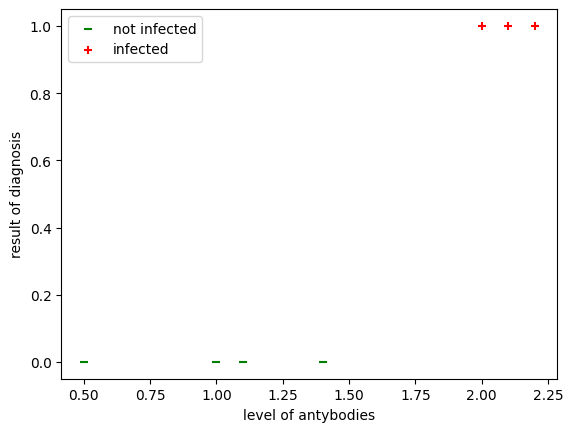

In [ ]:
# not infected
X1 = [0.5, 1, 1.1, 1.4]
Y1 = np.zeros(len(X1))

# infected
X2 = [2, 2.1, 2.2]
Y2 = np.ones(len(X2))

plt.scatter(X1, Y1, color="g", marker="_", label="not infected")
plt.scatter(X2, Y2, color="r", marker="+", label="infected")
plt.xlabel("level of antybodies")
plt.ylabel("result of diagnosis")
plt.legend()
plt.show()

### Classification with linear regression
First we are going to try to perform classification using linear regression (this time from sklearn).

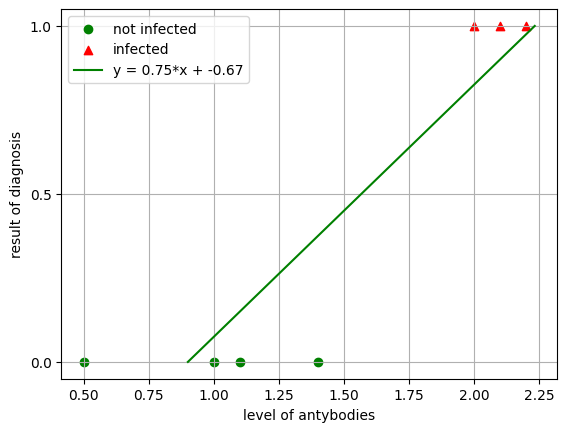

f(1.57)=0.50


In [ ]:
# not infected
X1 = [0.5, 1, 1.1, 1.4]
Y1 = np.zeros(len(X1))

# infected
X2 = [2, 2.1, 2.2]
Y2 = np.ones(len(X2))

plt.scatter(X1, Y1, color="g", marker="o", label="not infected")
plt.scatter(X2, Y2, color="r", marker="^", label="infected")
plt.xlabel("level of antybodies")
plt.ylabel("result of diagnosis")

# linear regression line
X = np.append(X1, X2).reshape(-1, 1)  # reshape from single row into single column
Y = np.append(Y1, Y2)
reg = LinearRegression().fit(X, Y)

# y = ax + b
a = reg.coef_[0]
b = reg.intercept_

# x = (y-b)/a
Y = np.linspace(0, 1, 100)
X = Y/a - b/a
plt.plot(X, Y, c ="g", label=f"y = {a:.2f}*x + {b:.2f}")
plt.legend()
plt.yticks([0, 0.5, 1])
plt.grid()
plt.show()

threshold = 0.5
x_border = (threshold-b)/a
print(f"f({x_border:.2f})={threshold:.2f}")

It seems that we can use predictions from the regression line to classify new cases: for a given $x$ if $reg.predict(x) \geq 0.5$ we could classify the patient as infected. This works because the data in the example was chosen carefully. Linear regression stops working if we add more extreme measurements or have more classes. Also, it is not immediately clear how likely the value is in a chosen class. Note that in the following example, some points are misclassified.

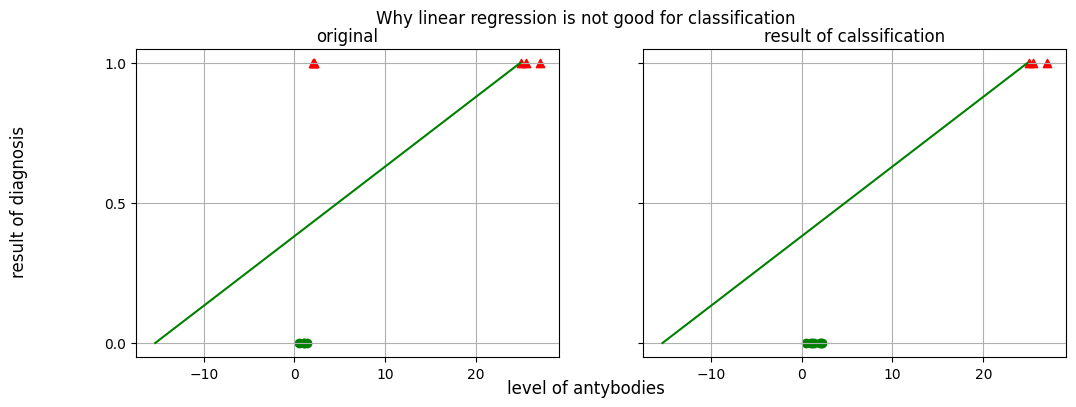

In [ ]:
# not infected
X1 = [0.5, 1, 1.1, 1.4]
Y1 = np.zeros(len(X1))

# infected
X2 = [2, 2.1, 2.2, 25, 25.5, 27]
Y2 = np.ones(len(X2))

# linear regression line
X = np.append(X1, X2).reshape(-1, 1)
Y = np.append(Y1, Y2)
reg = LinearRegression().fit(X, Y)

# y = ax + b
a = reg.coef_[0]
b = reg.intercept_

# x = (y-b)/a
y = np.linspace(0, 1, 100)
x = y/a - b/a

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,4))
fig.suptitle("Why linear regression is not good for classification")
fig.supxlabel("level of antybodies")
fig.supylabel("result of diagnosis")
ax1.set_yticks([0, 0.5, 1])
ax1.scatter(X1, Y1, color="g", marker="o", label="not infected")
ax1.scatter(X2, Y2, color="r", marker="^", label="infected")
ax1.plot(x, y, c ="g", label=f"y = {a:.2f}*x + {b:.2f}")
ax1.grid()
ax1.set_title("original")

# flawed result of classification
X = np.append(X1,X2).reshape(-1, 1)
Y = np.append(Y1,Y2)
X1 = X[reg.predict(X) < 0.5]
X2 = X[reg.predict(X) >= 0.5]

ax2.scatter(X1, np.zeros(X1.size), color="g", marker="o", label="not infected")
ax2.scatter(X2, np.ones(X2.size), color="r", marker="^", label="infected")
ax2.plot(x, y, c ="g", label=f"y = {a:.2f}*x + {b:.2f}")
ax2.grid()
ax2.set_title("result of calssification")

plt.show()

Note that the large values in this case are not outliers.

### Logistic function

We can remedy the problems by applying the *logistic* function: $\sigma(x) = \frac{1}{1 + e^{-x}} = \frac{e^x}{e^x + 1}$, which is an example of *sigmoid* (S-shaped) function.

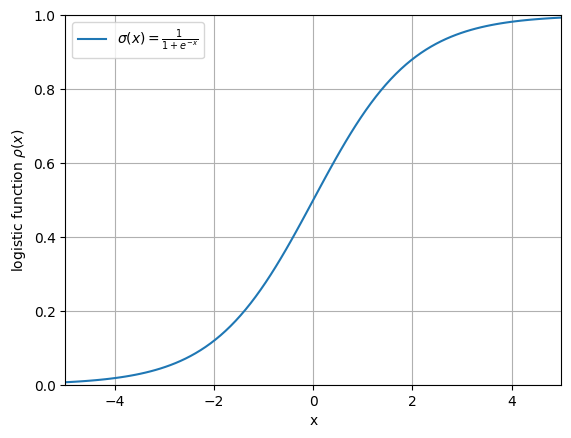

In [ ]:
x_min, x_max = -5, 5
# x_min, x_max = -10, 10
# x_min, x_max = -100, 100

x = np.linspace(x_min, x_max, 100)
y = 1/(1 + np.exp(-x))
plt.plot(x, y, label=r"$\sigma(x)= \frac{1}{1+e^{-x}}$")
plt.xlabel("x")
plt.ylabel(r"logistic function $\rho(x)$")
plt.xlim(x_min, x_max)
plt.ylim(0, 1)
plt.grid()
plt.legend()
plt.show()

### Classification with logistic regression function

Assuming d-dimensional space, $\mathbf{x} = (x_1, \ldots, x_d)$ and that there are $n$ training examples $\mathbf{x_1}, \ldots, \mathbf{x_n} \in \mathbb{R}_d$ with $y_1, \dots, y_n \in \{0,1\}$ we have:
* Linear function or more formally [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) <br/> $f(\mathbf{x}) = b_d⋅x_d + \ldots + b_1⋅x_1 + b_0$, <br/> with $b_d, \ldots, b_0$ being the predicted weights of the coeficients,
* Logistic function $\sigma(x) = \frac{1}{1 + e^{-x}} = \frac{e^x}{e^x + 1}$,
* Logistic regression function  $\rho(\mathbf{x}) = \sigma(f(\mathbf{x})) = \frac{1}{1 + e^{-f(\mathbf{x})}} = \frac{e^{f(\mathbf{x})}}{e^{f(\mathbf{x})} + 1}$<br/>
(note that $f(\mathbf{x})=\log(\frac{\rho(\mathbf{x})}{1-\rho(\mathbf{x})})$, see [logit](https://en.wikipedia.org/wiki/Logit)),
* Log-likelihood function $LLF = \sum_{i=1..n}y_i \log(\rho(\mathbf{x_i}))+(1-y_i)\log(1-\rho(\mathbf{x_i}))$.

We will be **maximizing** LLF, i.e., looking for coefficients $b_d, \ldots, b_0$ such that LLF is maximized.


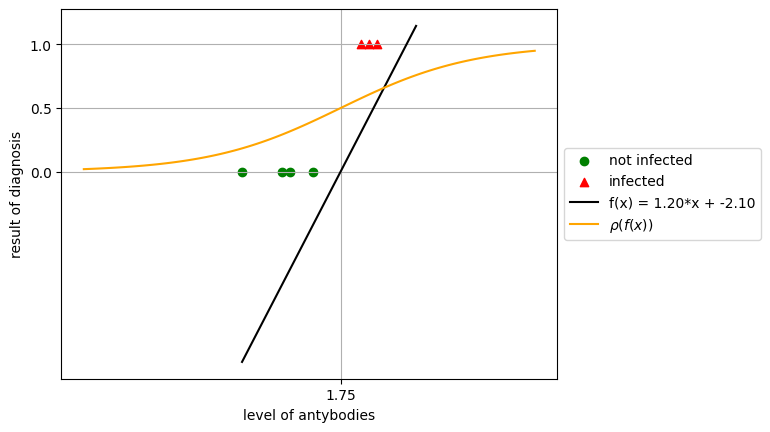

f(1.75)=0.00
g(f(1.75))=0.50


In [ ]:
# not infected
X1 = [0.5, 1, 1.1, 1.4]
Y1 = np.zeros(len(X1))

# infected
X2 = [2, 2.1, 2.2]
Y2 = np.ones(len(X2))

plt.scatter(X1, Y1, color="g", marker="o", label="not infected")
plt.scatter(X2, Y2, color="r", marker="^", label="infected")
plt.xlabel("level of antybodies")
plt.ylabel("result of diagnosis")

# LOGISTIC regression
X = np.append(X1, X2).reshape(-1, 1)
Y = np.append(Y1, Y2)
lr = LogisticRegression().fit(X, Y)

# y = ax + b
a = lr.coef_[0][0]
b = lr.intercept_[0]

# x = (y-b)/a
X_small = np.linspace(np.min(X), np.max(X)+0.5, 100)
X_large = np.linspace(np.min(X)-2, np.max(X)+2, 100)
Y_lin = X_small*a + b
Y_log = 1/(1+np.e**(-X_large*a - b))
plt.plot(X_small, Y_lin, c ="black", label=f"f(x) = {a:.2f}*x + {b:.2f}")
plt.plot(X_large, Y_log, c ="orange", label=r"$\rho(f(x))$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks([1.75])
plt.yticks([0, 0.5, 1])
plt.grid()
plt.show()

threshold = 0
x_border = (threshold-b)/a
print(f"f({x_border:.2f})={threshold:.2f}")
print(f"g(f({x_border:.2f}))={(1./(1+np.e**(-threshold))):.2f}")

### Exercise 1
Try logistic regression on the dataset which caused trouble for linear regression. See if the learned logistic regression function separates the data properly. For that, plot the results of the classification on the training data. Also, plot the linear function backing the logistic regression function.

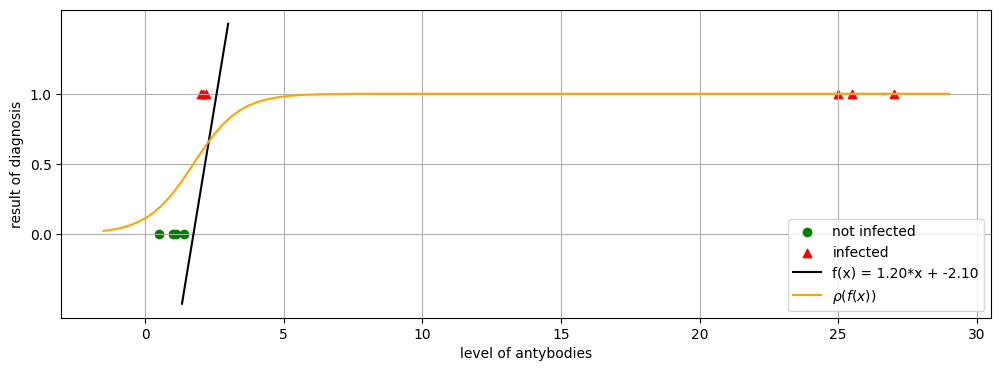

f(1.75)=0.00
g(f(1.75))=0.50


In [ ]:
#@title Solution


### Exercise 2
The value that the logistic regression assigns for particular input can be interpreted as the probability of being in the positive (=1) class. Compute the average fitted probability over all the values from the previous example and compare it to the initial proportion of values in the positive (=1) class.

In [ ]:
#@title Solution


avg. prob = 0.6, proportion = 0.6


### Question
What if infected individuals are very rare in the population, so that if we sample people randomly, most of the data will represent non-infected cases, with only a small percentage being infected? However, the dataset we use to train logistic regression is more balanced, meaning a large percentage of cases represent infected individuals. Does this imbalance affect logistic regression results? If so, how can we mitigate this issue?

We are now going to deal with a 2D example.

### Exercise 3
The following code loads the [Iris](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) dataset from the scikit-learn and projects it to the first two features (`Sepal length` and `Sepal width`). Train the logistic regression model on this data. Plot a line separating the Setosa species from the rest. Make sure the line is consistent with the decision boundary visualization obtained with [DecisionBoundaryDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html). Can you explain how such a line can be obtained from the model?

Hint: Look at `LogisticRegression.coef_` and note its shape.

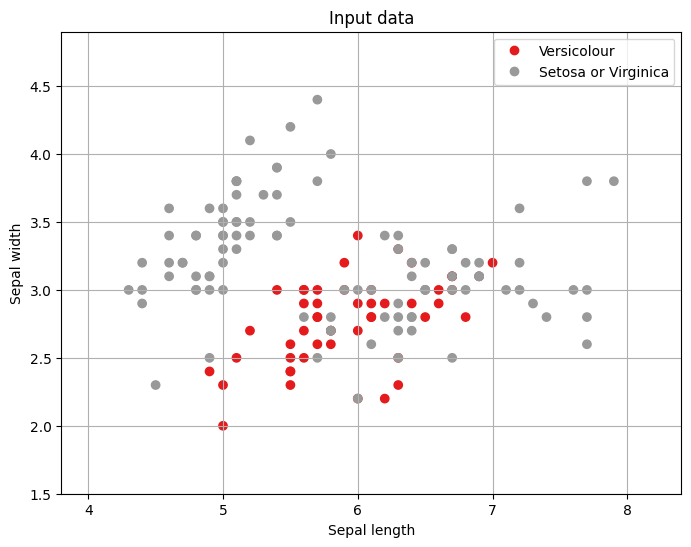

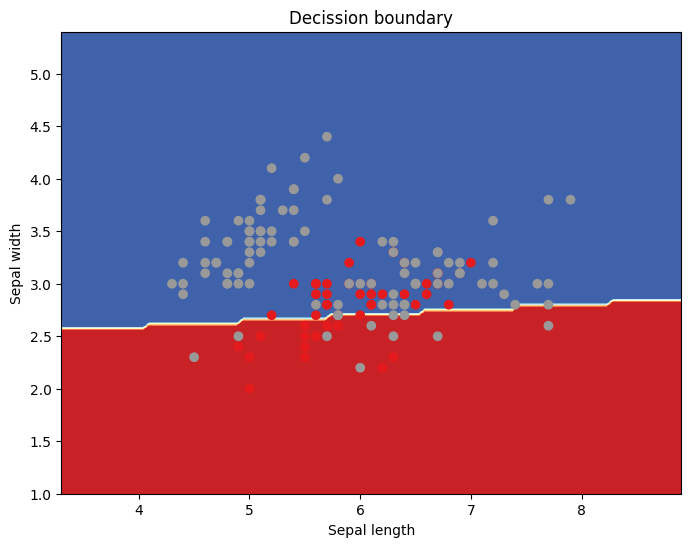

In [ ]:
iris = datasets.load_iris()
datasets.load_iris?
X = iris.data[:, :2]
Y = [int(x != 1) for x in iris.target]

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Set1)
plt.title("Input data")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")
plt.legend(handles=scatter.legend_elements()[0], labels=["Versicolour", "Setosa or Virginica"])
plt.grid()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

lr = LogisticRegression().fit(X, Y)

from sklearn.inspection import DecisionBoundaryDisplay
plt.figure(figsize=(8,6))
plt.title("Decission boundary")
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    lr,
    X,
    cmap=plt.cm.RdYlBu,
    response_method="predict",
    ax=ax,
    xlabel="Sepal length",
    ylabel="Sepal width",
)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Set1)
plt.show()

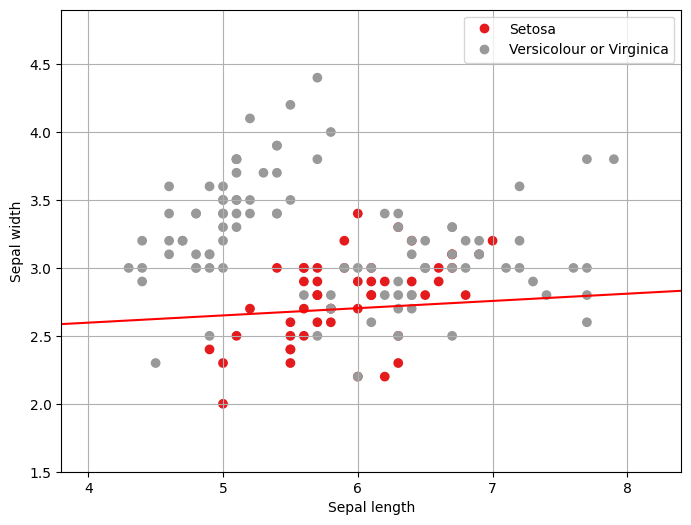

In [ ]:
#@title Solution


## Metrics to measure classification performance
In this case, the classification looks far from being perfect. Let us check the correctness of the result and how it matches the original data.

In [ ]:
z = list(zip(Y,lr.predict(X)))
print(z)

matching = sum([y == prediction for y,prediction in z])
all = len(z)

print(f"matching/all = {matching/all}")  # ratio of the number of correct predictions to the number of observations

[(1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 0), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (0, 1), (0, 1), (0, 1), (0, 0), (0, 1), (0, 1), (0, 1), (0, 0), (0, 1), (0, 1), (0, 0), (0, 1), (0, 0), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 0), (0, 0), (0, 1), (0, 1), (0, 0), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 1), (0, 1), (0, 1), (0, 0), (0, 1), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 1), (0, 1), (0, 1), (0, 1), (0, 0), (0, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 0), (1, 1), (1, 0), (1, 1), (1, 1), (1, 0), (1, 1), (1, 0), (1, 1), (1, 1), (1, 1), (1, 1), (1, 0), (1, 0), (1, 1), (1, 1), (1, 1), (1, 0), (1, 1),

Actually this ratio is calle *accuracy* and there is a built-in method to compute it.

In [ ]:
lr.score(X, Y)  # mean accuracy on the given test data and labels

0.7133333333333334

We can also obtain the confusion matrix which contains information about true/false positives/negatives. $C_{i,j}$ gives the number of observations from class $i$ to be predicted in class $j$. In the case of binary classification, this gives:
* True negatives in $C_{0,0}$ (the upper-left position),
* False negatives in $C_{1,0}$ (the lower-left position),
* False positives in $C_{0,1}$ (the upper-right position),
* True positives in $C_{1,1}$ (the lower-right position).

In our example this confusion matrix is 2x2.


In [ ]:
C = confusion_matrix(Y, lr.predict(X))
C

array([[17, 33],
       [10, 90]])

### Exercise 4
Based on the confusion matrix compute: (1) the total number of correct classifications, (2) the total number of incorrect classifications, (3) classification accuracy, (4) the error level.

In [ ]:
#@title Solution


(1) = 90 + 17 = 107
(2) = 33 + 10 = 43
ACC = 71%
ERR = 29%


### Exercise 5
Based on the confusion matrix compute: (1) Sensitivity/True Positive Rate (TPR), (2) Specificity/True Negative Rate (TNR), (3) Precision/Positive Predictive Value (PPV), (4) Negative Predictive Value (NPV).

In [ ]:
#@title Solution


TPR=90%, TNR=34%, PPV=73%, NPV=63%


We can also produce the following classification report:

In [ ]:
print(classification_report(Y, lr.predict(X)))

              precision    recall  f1-score   support

           0       0.63      0.34      0.44        50
           1       0.73      0.90      0.81       100

    accuracy                           0.71       150
   macro avg       0.68      0.62      0.62       150
weighted avg       0.70      0.71      0.69       150



You can read more about scores and their relations at [wikipedia](https://en.wikipedia.org/wiki/Positive_and_negative_predictive_values) and in this [paper](https://www.sciencedirect.com/science/article/pii/S0306457309000259).

### Multiclass logistic regression

A general and common method of dealing with multiple classes is to train regression for each class separately and then use *softmax coding*: $P(Y = k | X = x) = \frac{e^{\beta_k,0 + \beta_k,1 x_1 + \ldots + \beta_k,d x_d}}{\sum_{j=1}^K e^{\beta_j,0 + \beta_j,1 x_1 + \ldots + \beta_j,d x_d}}$. As a result of classification we then choose the class with the biggest probability.



### Preparing data for real-life analysis
So far we have trained models on the whole dataset and we haven't prepared the data in any way. In real-life scenarios we should always consider the following steps:
1. cleaning the data,
2. checking if the method requires feature scaling (logistic regression does not require it, but doing it has some beneficial effects: it improves the convergence of gradient-based optimization algorithms and ensures that regularization techniques, like L1 and L2, are applied uniformly across all features),
3. splitting the data into train and test datasets to avoid overfitting,
4. checking for overfitting and quality of the resulting model.

### Exercise 6
Train logistic regression model for the iris dataset using all the features and all the classes. Perform all the recommended steps. Explain how multiple classes are included in the model. Are the numerical values that we assign to classes important?

Hint: Use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [ ]:
#@title Solution


train accuracy: 0.8583333333333333
test accuracy: 0.7
[[11  0  0]
 [ 0  4  9]
 [ 0  0  6]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.31      0.47        13
           2       0.40      1.00      0.57         6

    accuracy                           0.70        30
   macro avg       0.80      0.77      0.68        30
weighted avg       0.88      0.70      0.68        30



## Linear discriminant analysis (LDA)

Linear discriminant analysis (LDA) is another method that can be used for classification. Here the assumption is that the data for particular classes follows the normal distribution (Gausian distribution) with probability density function given by:
* $f(x|\mu, \sigma) = \frac{1}{\sigma \sqrt{2\pi} } e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2}$ for single dimension,
* $f({\mathbf x}|\boldsymbol\mu, \Sigma) = \frac{1}{\sqrt{(2\pi)^k |\boldsymbol\Sigma|}} e^{-\frac 1 2 ({\mathbf x} - {\boldsymbol\mu})^\mathrm{T}{\boldsymbol\Sigma}^{-1}({\mathbf x}-{\boldsymbol\mu})}$, otherwise, where $k$ is the number of dimensions, $\boldsymbol\Sigma$ is the covariance matrix and $|\boldsymbol\Sigma|\equiv \det\boldsymbol\Sigma$ (see [wikipedia](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) for more details). Each class can have its own mean, but all classes are assumed to have the same variance/covariance matrix.

Recall information about [covariance](https://en.wikipedia.org/wiki/Covariance) and [covariance in multidimensional case](https://en.wikipedia.org/wiki/Covariance_matrix).

Can you spot in these equations the Z-score and [Mahalanobis_distance](https://en.wikipedia.org/wiki/Mahalanobis_distance) (they give normalized distance to mean)?

Note that if the data is not normally distributed you can try to make it by applying log transformation, but be [cautious](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4120293/).

Let us explore the iris dataset further. This time we are going to look at a histogram of Sepal lengths for Setosa and Versicolor.

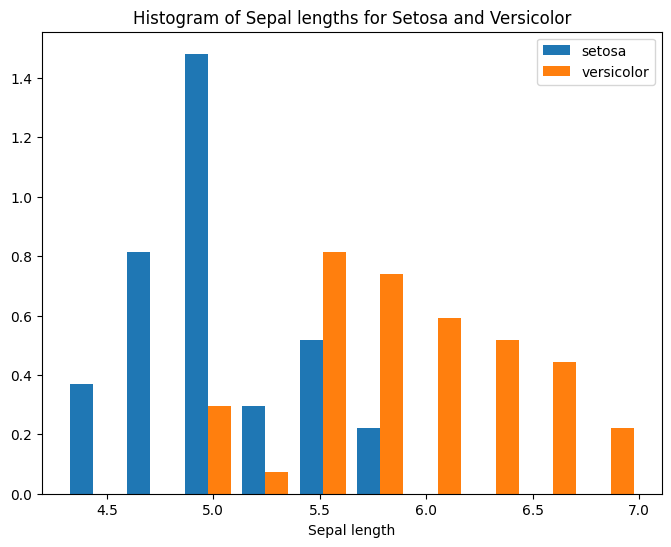

In [ ]:
iris = datasets.load_iris()  # setosa, versicolor, virginica
sepal_len = iris.data[:, 0]
# print(list(iris.target_names))  # ['setosa', 'versicolor', 'virginica']
X_se = sepal_len[iris.target == 0]
X_ve = sepal_len[iris.target == 1]
X = sepal_len[iris.target != 2]
Y = iris.target[iris.target != 2]

plt.figure(figsize=(8, 6))
plt.hist([X_se, X_ve], 10, density=True, histtype='bar', label=iris.target_names[0:2])
plt.legend()
plt.title('Histogram of Sepal lengths for Setosa and Versicolor')
plt.xlabel("Sepal length")

plt.show()

If we assume the data is normally distributed for each species, then we get:

In [ ]:
mu_se = np.mean(X_se)
mu_ve = np.mean(X_ve)
s_se = np.std(X_se)  # note that LDA uses one std for both classes
s_ve = np.std(X_ve)
print(f"mu_se={mu_se:.2f} s_se={s_se:.2f}\nmu_ve={mu_ve:.2f} s_ve={s_ve:.2f}")

mu_se=5.01 s_se=0.35
mu_ve=5.94 s_ve=0.51


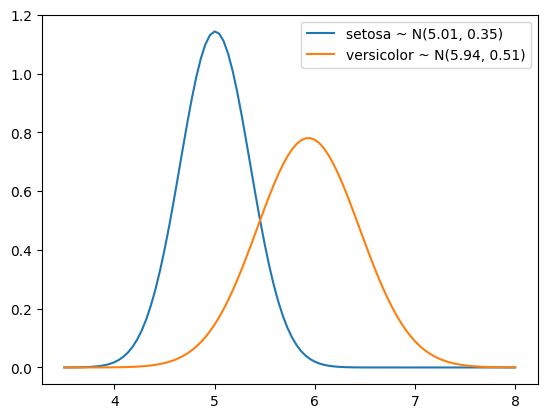

In [ ]:
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2*np.pi)*sigma)*np.exp(-0.5 * (1./sigma*(x - mu))**2)

linspace = np.linspace(3.5, 8, 100)

for species, mu, sigma in [("setosa", mu_se, s_se), ("versicolor", mu_ve, s_ve)]:
    plt.plot(linspace, gaussian(linspace, mu, sigma), label=f"{species} ~ N({mu:.2f}, {sigma:.2f})")

plt.legend()
plt.show()

With this, we can classify values to the class for which the likelihood of its distribution parameters is the highest (the distance from the mean is the smallest).

Given $x$ the likelihood of distribution parameters $\mu$ and $\sigma$ is the same as probability density of $x$ given distribution parameters: $L(\mu, \sigma|x) = f(x|\mu, \sigma)$. For multidimensional case we have $\boldsymbol\mu$, $\Sigma$ and $L(\boldsymbol\mu, \Sigma|{\mathbf x}) = f({\mathbf x}|\boldsymbol\mu, \Sigma)$, respectively.

We can also compute probability using Bayes rule $P(y=Y_k) = \frac{\pi_kL(y=Y_k|x)}{\Sigma_{i}\pi_iL(y=Y_i|x)}$, where $\pi_k$ is the prior probability that observation belongs to class $k$.

It can be shown that this is equivalent to assigning the observation to a class for which: $\delta_k(x) = x \frac{\mu_k}{\sigma^2} - \frac{\mu_k^2}{2\sigma^2} + \log(\pi_k)$ is the largest. LDA classifies observation the the class for which this value is the biggest.

Note that: $\pi_k$, $\mu_k$ ($\boldsymbol\mu_k$) and the common $\sigma$ ($\boldsymbol\Sigma$) can be estimated from the training data.

### Exercise 7
Now plot the histogram and the distributions for all 3 classes.

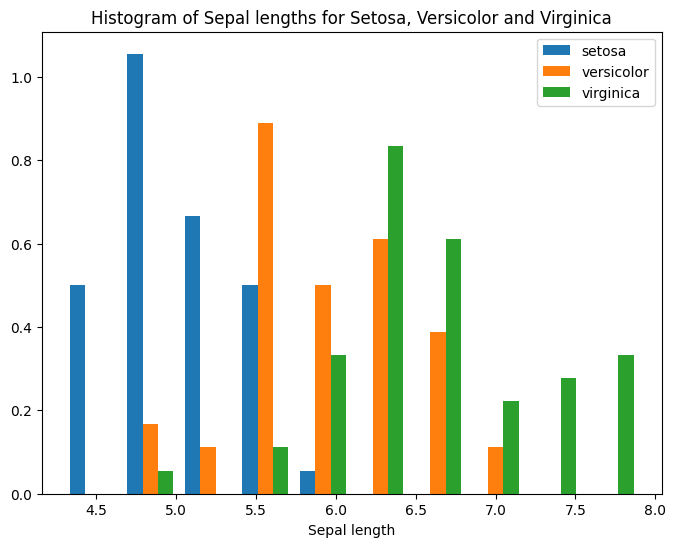

mu_se=5.01 s_se=0.35
mu_ve=5.94 s_ve=0.51
mu_vi=6.59 s_vi=0.63


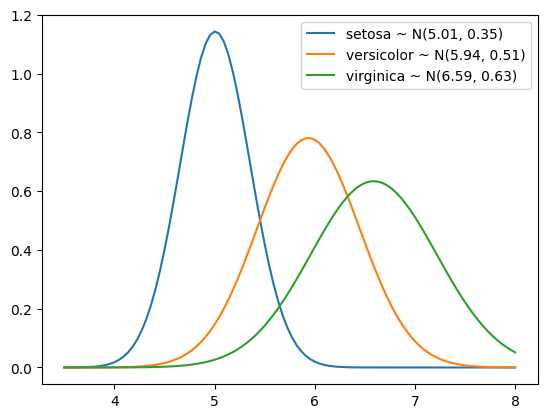

In [ ]:
#@title Solution


### Exercise 8
Train LDA for the iris dataset using all the features, all the classes, and all the dimensions. Perform all the recommended steps. Note that for LDA (the same as PCA) feature scaling is required. Compare accuracy versus the logistic regression version. Explain how multiple classes are included in the model. Are the numerical values that we assign to classes important?

Hint: Use [sklearn.discriminant_analysis.LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html).



In [ ]:
#@title Solution


train accuracy: 0.875
test accuracy: 0.7666666666666667
[[11  0  0]
 [ 0  7  6]
 [ 0  1  5]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.88      0.54      0.67        13
           2       0.45      0.83      0.59         6

    accuracy                           0.77        30
   macro avg       0.78      0.79      0.75        30
weighted avg       0.84      0.77      0.77        30



## Quadratic Discriminant Analysis (QDA)

In LDA we assume that all the classes have the same variance (there is a common covariance matrix), but if we have a lot of training data, then we can estimate distinct values for each class. In that case the $\delta_k(x)$ definition changes. Recall that we have computed such values for all the classes and picked the class with the greatest value. For LDA this is a linear function. For distinct variances (covariance matrices) in QDA this is no longer the case as the function is quadratic: $\delta_k(x) = -\frac{1}{2} (x-\mu_k)^T \Sigma_k^{-1} (x-\mu_k) -\frac{1}{2} \log |\Sigma_k| + \log(\pi_k)$.

See the corresponding sklearn class: [QuadraticDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html).

### Exercise 9
You can gain intuition on how the distribution of the data changes depending on the parameters by playing with the following example. Note that, if the same covariance is used for both classes, then the border (defined by the points with the same probability of being in either of the classes) is linear and otherwise quadratic. Change the parameters and make sure you understand how the multivariate Gaussian distribution works.

Hint: See Chapter 4.5 *A Comparison of Classification Methods* in the book for a discussion on when the classifiers work the best.

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.pylab as pl
from scipy.stats import multivariate_normal
from sklearn.utils.extmath import cartesian

def prep_color_map(cm):
  fading_map = cm(np.arange(cm.N)) # extract colors
  fading_map[:, -1] = np.linspace(0, 1, cm.N) # modify alpha
  fading_map = ListedColormap(fading_map) # convert to colormap
  return fading_map

fading_red = prep_color_map(pl.cm.Reds)
fading_blue = prep_color_map(pl.cm.Blues)


def plot_distr_and_border(mean1, cov1, mean2, cov2):
  x1 = np.random.multivariate_normal(mean1, cov1, 500000)
  x2 = np.random.multivariate_normal(mean2, cov2, 500000)
  plt.figure(figsize=(8, 6))
  plt.hist2d(x1[:, 0], x1[:, 1], bins=70, cmap=fading_blue)
  plt.hist2d(x2[:, 0], x2[:, 1], bins=70, cmap=fading_red)
  plt.grid()
  ax = plt.gca()
  xlim = ax.get_xlim()
  ylim = ax.get_ylim()
  xlin = np.linspace(xlim[0], xlim[1], 200)
  ylin = np.linspace(ylim[0], ylim[1], 200)
  grid = cartesian((xlin,ylin))

  dist1 = multivariate_normal(mean1,cov1)
  dist2 = multivariate_normal(mean2,cov2)
  pdf1 = np.reshape(dist1.pdf(grid),(xlin.size, ylin.size))
  pdf2 = np.reshape(dist2.pdf(grid),(xlin.size, ylin.size))

  border = dist1.pdf(grid) <= dist2.pdf(grid)
  data = grid[border]
  plt.tricontour(grid[:, 0], grid[:, 1], border)

  plt.show()

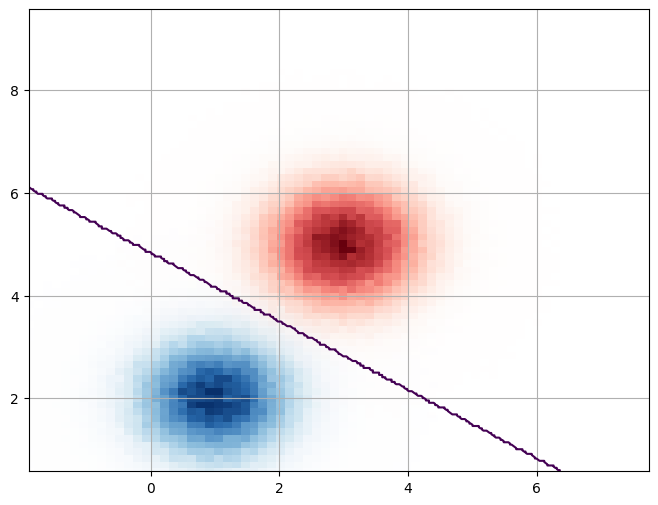

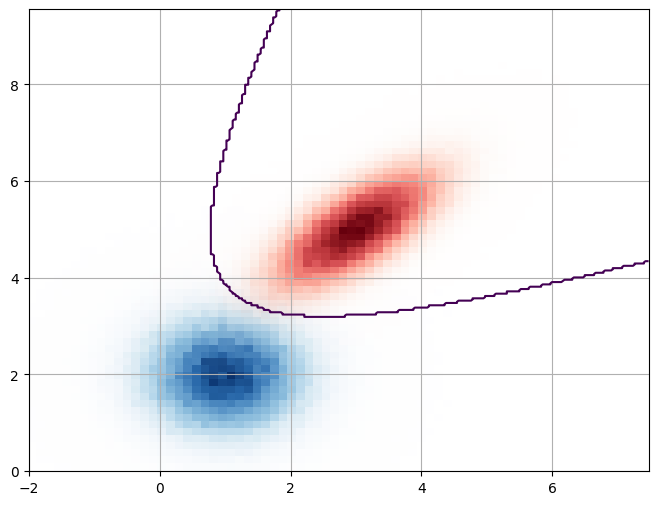

In [ ]:
mean1 = np.array([1,2])
cov1 = np.array([[1,0],[0,1]])  # cov must be a symmetric positive semidefinite matrix
mean2 = np.array([3,5])
cov2 = np.array([[1,0.7],[0.7,1]])  # cov must be a symmetric positive semidefinite matrix
plot_distr_and_border(mean1, cov1, mean2,cov1)
plot_distr_and_border(mean1, cov1, mean2,cov2)

## Naive Bayes

There is also a Bayes theorem based classifier which assumes conditional independence between every pair of features given the value of the class variable. Thanks to these oversimplified assumptions, this method requires less training data. It has a higher bias and smaller variance.

See the corresponding sklearn class: [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB).

## Homework
Use logistic regression to train a model to classify handwritten numbers. Use the following dataset. Measure the classification performance of your model.

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
[0 1 2 ... 8 9 8]


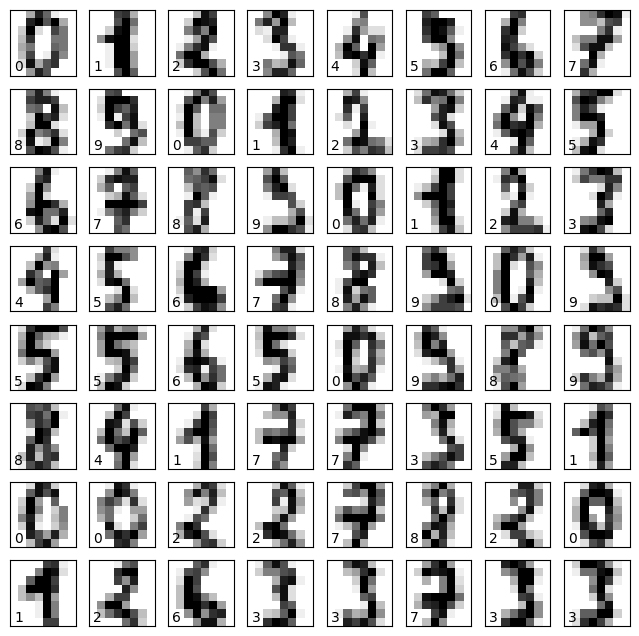

In [ ]:
from sklearn.datasets import load_digits
load_digits?
X, Y = load_digits(return_X_y=True)
print(X)
print(Y)

fig = plt.figure(figsize=(8, 8))

for i in range(64):
  ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
  ax.imshow(np.array(X[i]).reshape(8,8), cmap=plt.cm.binary, interpolation='nearest')
  # label the image with the target value
  ax.text(0, 7, str(Y[i]))

In [ ]:
#@title Solution


train accuracy: 0.964509394572025
test accuracy: 0.9416666666666667
[[27  0  0  0  0  0  0  0  0  0]
 [ 0 32  0  0  0  0  1  0  1  1]
 [ 1  1 33  1  0  0  0  0  0  0]
 [ 0  0  1 28  0  0  0  0  0  0]
 [ 0  0  0  0 29  0  0  1  0  0]
 [ 0  0  0  0  0 39  0  0  0  1]
 [ 0  1  0  0  0  0 43  0  0  0]
 [ 0  0  0  0  0  0  0 39  0  0]
 [ 0  2  1  2  0  0  0  1 33  0]
 [ 0  0  0  1  0  1  0  2  1 36]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        27
           1       0.89      0.91      0.90        35
           2       0.94      0.92      0.93        36
           3       0.88      0.97      0.92        29
           4       1.00      0.97      0.98        30
           5       0.97      0.97      0.97        40
           6       0.98      0.98      0.98        44
           7       0.91      1.00      0.95        39
           8       0.94      0.85      0.89        39
           9       0.95      0.88      0.91        41

    a

## Further reading/materials ##
* [Dimensionality reduction using Linear Discriminant Analysis](https://scikit-learn.org/stable/modules/lda_qda.html#dimensionality-reduction-using-linear-discriminant-analysis)
* [Confusion Matrix Visualization](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea)
* [Naive Bayes Classifier](https://scikit-learn.org/stable/modules/naive_bayes.html). See Chapter 4.5 *A Comparison of Classification Methods* in the book for a discussion on when the classifiers work the best.
* [Generalized Linear Model with a Poisson distribution](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PoissonRegressor.html). See Chapter 4.6 Generalized Linear Models in the [book](https://hastie.su.domains/ISLP/ISLP_website.pdf) for discussion.
* Generation of a random n-class classification problem with [sklearn.datasets.make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html).
* [DecisionBoundaryDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html#sklearn.inspection.DecisionBoundaryDisplay.from_estimator)
* [RocCurveDisplay](https://scikit-learn.org/stable/visualizations.html#visualizations)
* [imbalanced-learn](https://imbalanced-learn.org/stable/index.html) an open source, MIT-licensed library relying on scikit-learn and provides tools when dealing with classification with imbalanced classes

<center><img src='https://drive.google.com/uc?id=1_utx_ZGclmCwNttSe40kYA6VHzNocdET' height="60">

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'>


Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej".   
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>